<a href="https://colab.research.google.com/github/Junruiethel/machine-learning/blob/main/Copy_of_EE599_ML_Systems_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2 EE599 Systems for Machine Learning, Fall 2023
University of Southern California

Instructors: Arash Saifhashemi, Murali Annavaram

## Prerequisites:

* Set the runtime type to GPU. (Runtime -> Change Runtime Type)

# Initial Setup

This section imports all required packages from PyTorch.



In [1]:
#%matplotlib inline
import scipy.ndimage as ndi
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
grays=plt.get_cmap('gray')
np.set_printoptions(precision=2)


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from copy import deepcopy


import inspect
import re
import pprint

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys, os
figures_dir = '/content/drive/MyDrive/UtilFolder/hw2_figures'
weights_dir = '/content/drive/MyDrive/UtilFolder/weights'
data_dir = '/content/drive/MyDrive/UtilFolder/data'

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('gpu')

# Section 1: Convolution

**Definition**:
Convolution is a mathematical operation where a filter (or kernel) is applied over an input (e.g., image) to produce a modified output known as a feature map.

**Key Components**:
- **Kernel/Filter**: A small matrix that slides over the input. It captures patterns or features from the input.
  
- **Stride**: The number of pixels the filter moves at each step.
  
- **Padding**: Zeros added around the input's border, often used to control the output's spatial dimensions.

**Operation**:
The filter starts at the top-left corner of the image. For each position, values under the filter are multiplied with its corresponding filter values, then summed to produce a single pixel in the output. This process is repeated across the entire input.





## Create a sample image

Create a 2D  `image` of shape `(10,10)` as a numpy-array. The signal values are 1 (white) in the `(4,4)`-center region and 0 (black) elsewhere.

**TODO**: Plot the image as a grid with black or white colors and write the 0 or 1 value on each cell.

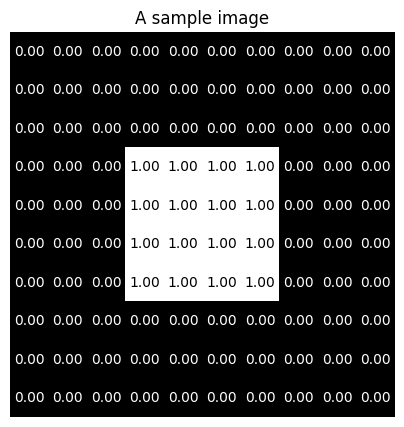

In [5]:
image=np.zeros((10,10))
image[3:7,3:7]=1
def plot_image_with_values(image, title):
    """
    Plots a 2D image with numeric values overlaid on each cell.

    Parameters:
    - image (2D numpy array): The image to be plotted.
    - title (str): The title of the plot.
    """
    plt.figure(figsize=(5,5))

    # Plot the image
    plt.imshow(image, cmap='gray')

    # Looping through all cells to overlay the numeric values
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value = image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)

    plt.title(title)
    plt.axis('off')
    plt.show()


plot_image_with_values(image, 'A sample image')


## Create an Average Filter

**TODO**: Create a 2-dimensional average filter of size 3x3.

To create a 2-dimensional average filter (also known as a mean filter) of size 3x3, the filter should consist of equal values such that they sum up to 1. For a 3x3 filter, each value in the filter should be $\frac{1}{9}$
  since there are 9 values in total.

- Use `conv2d` to colvolve this filter with `image`. Note that to do so, you have to convert the image from a numpy array to a tensor of appropriate size.
- Plot the image as a grid with black or white colors and write the 0 or 1 value on each cell.
- Explain the output.

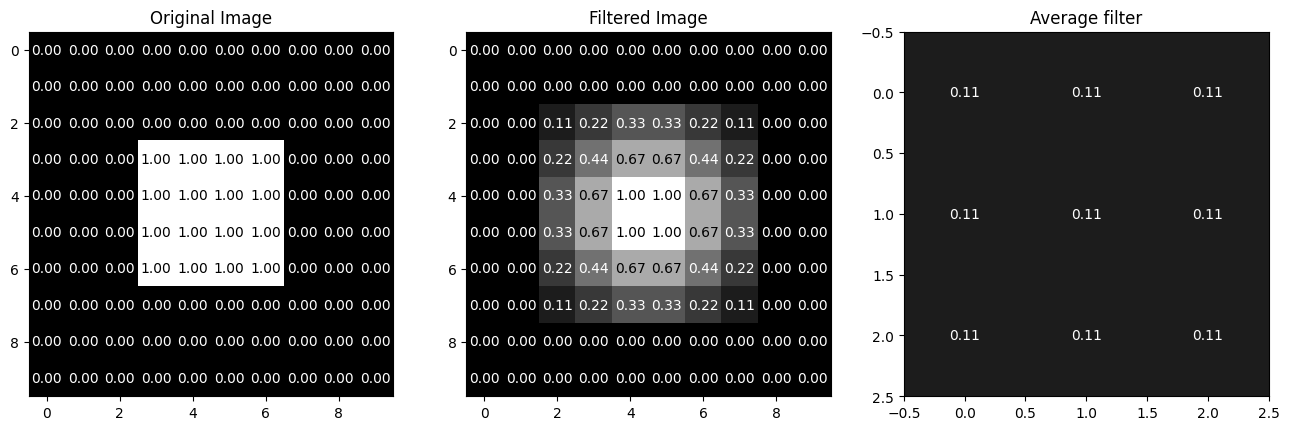

In [6]:
import scipy.ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import torch.nn.functional as F

# Create a 2D average filter of size 3x3
average_filter = np.ones((3, 3)) / 9.0

# Convert the image to a PyTorch tensor of appropriate size
image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Use convolution to apply the average filter to the image
filtered_image = F.conv2d(image_tensor, torch.tensor(average_filter, dtype=torch.float32).unsqueeze(0).unsqueeze(0), padding=1)

# Convert the filtered image tensor to a NumPy array
filtered_image = filtered_image.squeeze().numpy()

# Create a grayscale colormap for plotting
grayscale_cmap = plt.get_cmap('gray')

# Plot the original and filtered images
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap=grayscale_cmap, vmin=0, vmax=1)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
          pixel_value = image[i, j]
          text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
          plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(filtered_image, cmap=grayscale_cmap, vmin=0, vmax=1)
for i in range(filtered_image.shape[0]):
    for j in range(filtered_image.shape[1]):
          pixel_value = filtered_image[i, j]
          text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
          plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)
plt.title("Filtered Image")

plt.subplot(1, 3, 3)
plt.imshow(average_filter, cmap=grayscale_cmap, vmin=0, vmax=1)
for i in range(average_filter.shape[0]):
    for j in range(average_filter.shape[1]):
          pixel_value = average_filter[i, j]
          text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
          plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)
plt.title("Average filter")

plt.show()

## Edge Detection

In image processing, edge detection refers to the process of identifying abrupt changes or discontinuities in an image. These abrupt changes often correspond to object boundaries, textures, or other significant features.

The concept of **central differences** can be applied to images to detect edges by estimating the gradient magnitude at each pixel. In the context of images, the derivative approximations can highlight the areas of rapid intensity change, which are often the edges.


Create a 3x2 2-dimensional filter, which calculates the gradient in x-direction (detecting vertical edges).

Use of the concept of central differences. One possible filter for this purpose is:

\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{bmatrix}


**Question** Why is convolving the image with this filter analogous to computing the partial derivatives of the image with respect to x?

**TODO**: Create this filter and visualize it. Plot the filter as a grid with black or white colors and write the value of each cell on it.


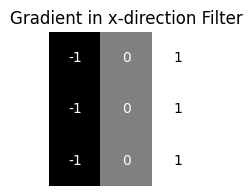

In [7]:
# Create the filter for gradient in x-direction
filter_x = np.array([[-1, 0, 1],
                     [-1, 0, 1],
                     [-1, 0, 1]])

# Plot the filter as a grid with black or white colors and values
plt.figure(figsize=(3, 2))
plt.imshow(filter_x, cmap='gray', vmin=-1, vmax=1)
plt.title("Gradient in x-direction Filter")
plt.axis('off')

# Add text labels for filter values
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{filter_x[i, j]:.0f}', ha='center', va='center',
                 color='white' if filter_x[i, j] < 0.5 else 'black')

plt.show()


**TODO:** Apply this filter on the original image.

Plot the image as a grid with black or white colors and write value of each cell on it.

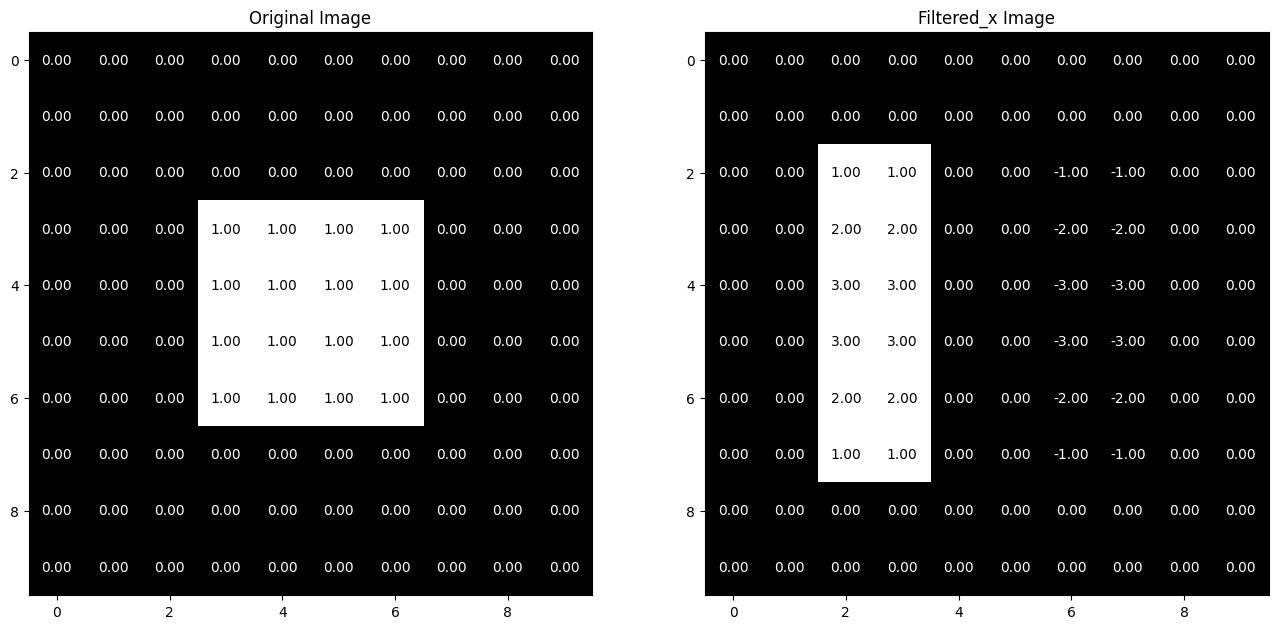

In [8]:

    # Use convolution to apply the average filter to the image
    xfiltered_image = F.conv2d(image_tensor, torch.tensor(filter_x, dtype=torch.float32).unsqueeze(0).unsqueeze(0), padding=1)

    # Convert the filtered image tensor to a NumPy array
    xfiltered_image = xfiltered_image.squeeze().numpy()

    # Create a grayscale colormap for plotting
    grayscale_cmap = plt.get_cmap('gray')

    # Plot the original and filtered images
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap=grayscale_cmap, vmin=0, vmax=1)
    # Looping through all cells to overlay the numeric values
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value = image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(xfiltered_image, cmap=grayscale_cmap, vmin=0, vmax=1)
    # Looping through all cells to overlay the numeric values
    for i in range(xfiltered_image.shape[0]):
        for j in range(xfiltered_image.shape[1]):
            pixel_value = xfiltered_image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)
    plt.title("Filtered_x Image")

    plt.show()

### Horizontal Edge
TODO:
Create a similar filter to detect horizontal edges.

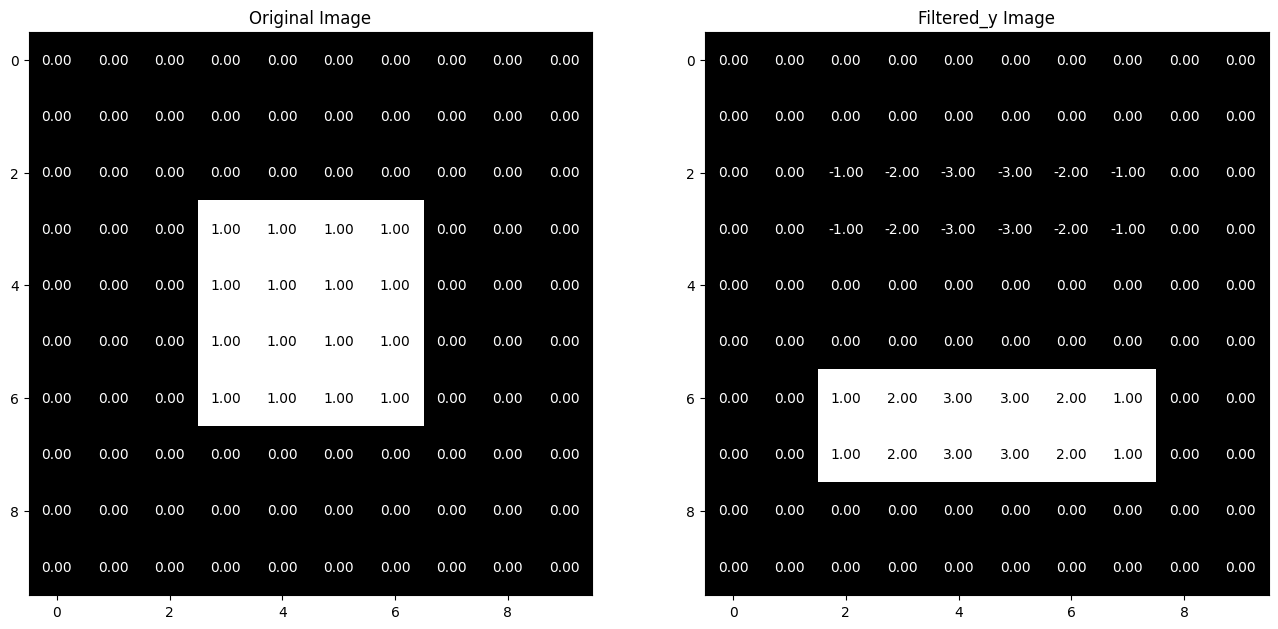

In [9]:
    # Create the filter for gradient in y-direction
    filter_y = np.array([[ 1, 1, 1],
                     [ 0, 0, 0],
                     [-1, -1, -1]])
    # Use convolution to apply the average filter to the image
    yfiltered_image = F.conv2d(image_tensor, torch.tensor(filter_y, dtype=torch.float32).unsqueeze(0).unsqueeze(0), padding=1)

    # Convert the filtered image tensor to a NumPy array
    yfiltered_image = yfiltered_image.squeeze().numpy()

    # Create a grayscale colormap for plotting
    grayscale_cmap = plt.get_cmap('gray')

    # Plot the original and filtered images
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap=grayscale_cmap, vmin=0, vmax=1)
    # Looping through all cells to overlay the numeric values
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value = image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(yfiltered_image, cmap=grayscale_cmap, vmin=0, vmax=1)
    # Looping through all cells to overlay the numeric values
    for i in range(yfiltered_image.shape[0]):
        for j in range(yfiltered_image.shape[1]):
            pixel_value = yfiltered_image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)
    plt.title("Filtered_y Image")

    plt.show()

### Laplacian Sharpening
Lapalacian filters can increase the regions of the image with rapid intensity. It is very helpful in hding the fine details of images. Any features with a sharp discontunioty will be enhanced.

One of the Laplacian filter is

\begin{bmatrix}
 0 & -1 &  0 \\
-1 &  4 & -1 \\
 0 & -1 &  0 \\
\end{bmatrix}

To sharpen an image ```img```:

1. use the Laplacian filter to convolve the original image to obtained a filter.
2. scale the filter into the range of the oringal image.
3. add the filter to the original image.
4. scale the summation to the range of the original image.


TODO: Create this filter and visualize it. Plot the filter as a grid with black or white colors and write the value of each cell on it.

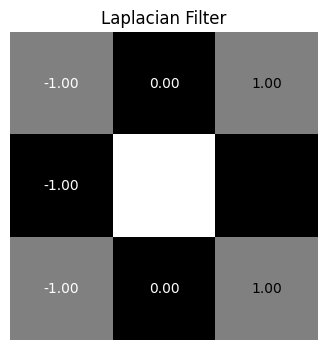

In [10]:
# Create the filter for gradient in x-direction
filter_laplacian = np.array([[0, -1, 0],
                     [-1, 4, -1],
                     [0, -1, 0]])

# Plot the filter as a grid with black or white colors and values
plt.figure(figsize=(8, 4))
plt.imshow(filter_laplacian, cmap='gray', vmin=-1, vmax=1)
plt.title("Laplacian Filter")
plt.axis('off')

# Add text labels for filter values
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{filter_x[i, j]:.2f}', ha='center', va='center',
                 color='white' if filter_x[i, j] < 0.5 else 'black')

plt.show()


TODO: Apply this filter on the original image.

Plot the image as a grid with black or white colors and write value of each cell on it.

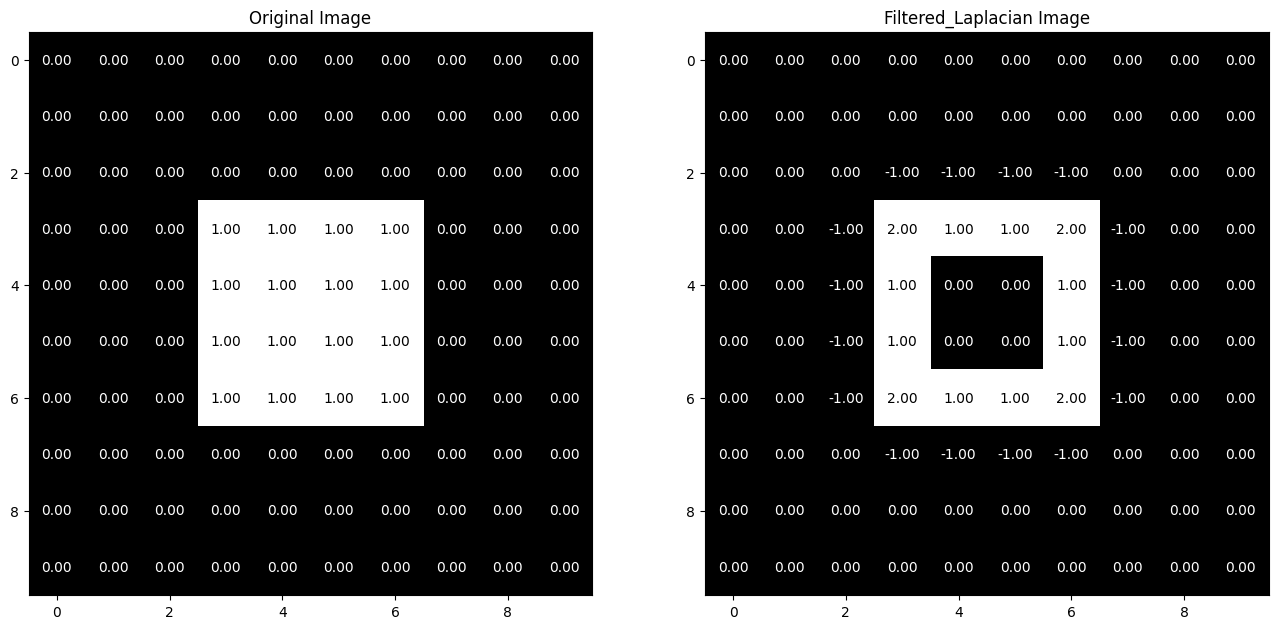

In [11]:
    # Use convolution to apply the average filter to the image
    laplacian_filtered_image = F.conv2d(image_tensor, torch.tensor(filter_laplacian, dtype=torch.float32).unsqueeze(0).unsqueeze(0), padding=1)

    # Convert the filtered image tensor to a NumPy array
    laplacian_filtered_image = laplacian_filtered_image.squeeze().numpy()

    # Create a grayscale colormap for plotting
    grayscale_cmap = plt.get_cmap('gray')

    # Plot the original and filtered images
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap=grayscale_cmap, vmin=0, vmax=1)
    # Looping through all cells to overlay the numeric values

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel_value = image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)

    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(laplacian_filtered_image, cmap=grayscale_cmap, vmin=0, vmax=1)
    # Looping through all cells to overlay the numeric values
    for i in range(laplacian_filtered_image.shape[0]):
        for j in range(laplacian_filtered_image.shape[1]):
            pixel_value = laplacian_filtered_image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)
    plt.title("Filtered_Laplacian Image")

    plt.show()

## Applying Filters on an Image

In this section we apply several filters on a real image.

**TODO**
Use `PIL` library to read the attached image called `cars-1638594_1280.jpg` as a numpy array. Convert that image to grayscale so that it only has a single channel and plot the image.

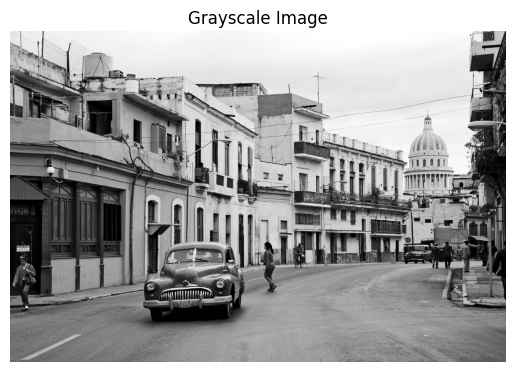

In [12]:
import os
os.chdir('/content/drive/My Drive/UtilFolder/hw2_figures')
from PIL import Image
# Load the image using PIL
image = Image.open("cars-1638594_1280.jpg")

# Convert the image to grayscale
grayscale_image = image.convert("L")

# Convert the grayscale image to a NumPy array
grayscale_array = np.array(grayscale_image)

# Plot the grayscale image
plt.imshow(grayscale_array, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()


**TODO**:
Apply the vertical edge detection to the image and plot both original and converted image.

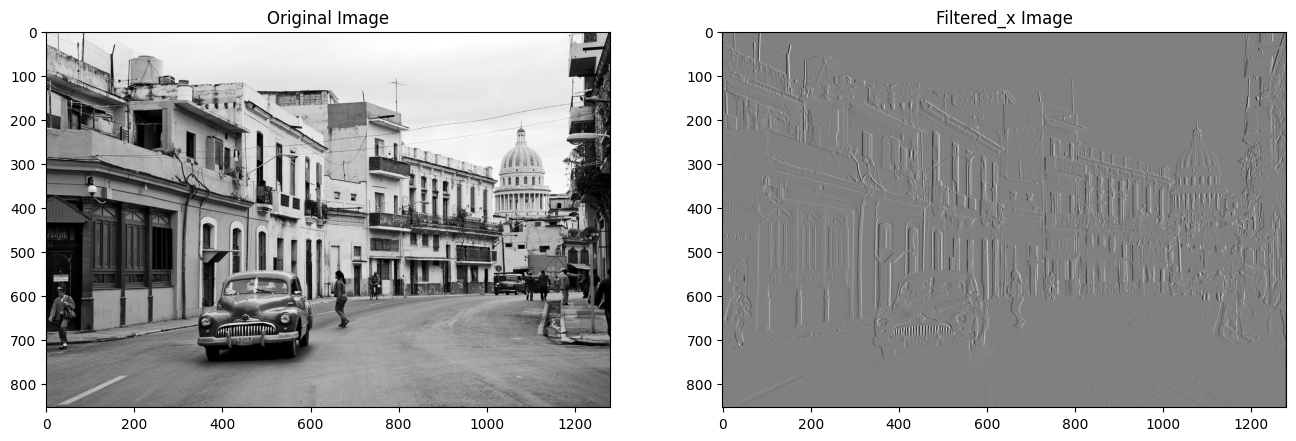

In [13]:

    # Convert the image to a PyTorch tensor of appropriate size
    image_tensor = torch.tensor(grayscale_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    # Use convolution to apply the average filter to the image
    xfiltered_image = F.conv2d(image_tensor, torch.tensor(filter_x, dtype=torch.float32).unsqueeze(0).unsqueeze(0), padding=1)
    # Convert the filtered image tensor to a NumPy array
    xfiltered_image = xfiltered_image.squeeze().numpy()
    # Plot the original and filtered images
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_array, cmap='gray')
    # Looping through all cells to overlay the numeric values

    for i in range(grayscale_array.shape[0]):
        for j in range(grayscale_array.shape[1]):
            pixel_value = grayscale_array[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value

    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(xfiltered_image, cmap='gray')
    # Looping through all cells to overlay the numeric values

    for i in range(xfiltered_image.shape[0]):
        for j in range(xfiltered_image.shape[1]):
            pixel_value = xfiltered_image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value

    plt.title("Filtered_x Image")
    plt.show()

**TODO**:
Apply the horizontal edge detection to the image and plot both original and converted image.




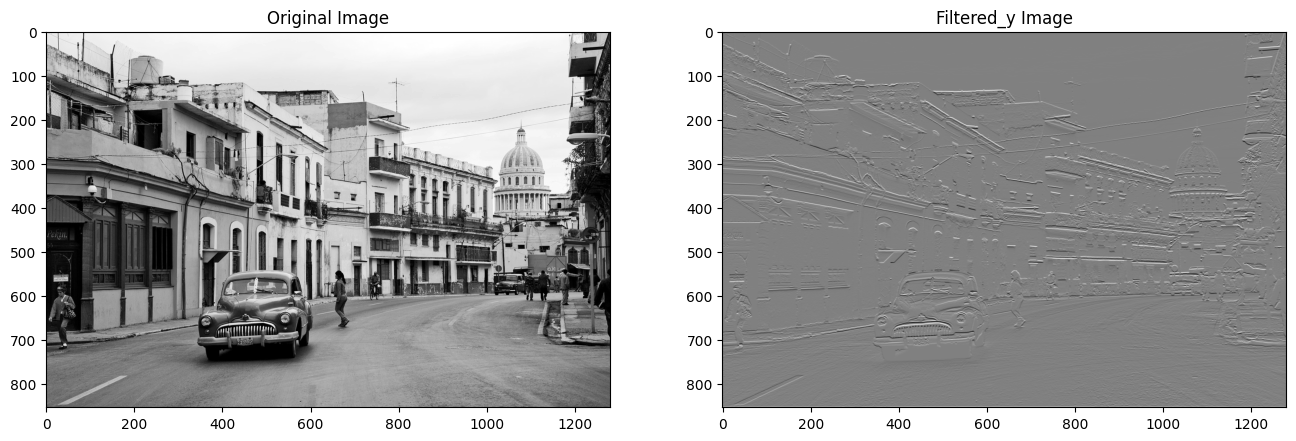

In [14]:
    # Use convolution to apply the average filter to the image
    yfiltered_image = F.conv2d(image_tensor, torch.tensor(filter_y, dtype=torch.float32).unsqueeze(0).unsqueeze(0), padding=1)
    # Convert the filtered image tensor to a NumPy array
    yfiltered_image = yfiltered_image.squeeze().numpy()
    # Plot the original and filtered images
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_array, cmap='gray')
    # Looping through all cells to overlay the numeric values

    for i in range(grayscale_array.shape[0]):
        for j in range(grayscale_array.shape[1]):
            pixel_value = grayscale_array[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value

    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(yfiltered_image, cmap='gray')
    # Looping through all cells to overlay the numeric values

    for i in range(yfiltered_image.shape[0]):
        for j in range(yfiltered_image.shape[1]):
            pixel_value = yfiltered_image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value

    plt.title("Filtered_y Image")
    plt.show()

**TODO**:
Apply the sharpening to the image and plot both original and converted image.




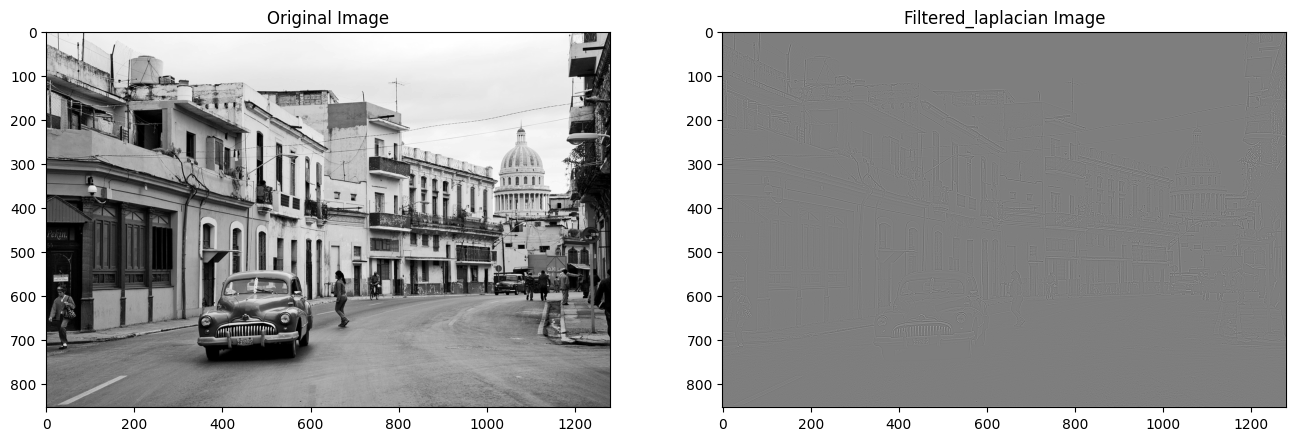

In [49]:
    # Use convolution to apply the average filter to the image
    laplacian_filtered_image = F.conv2d(image_tensor, torch.tensor(filter_laplacian, dtype=torch.float32).unsqueeze(0).unsqueeze(0), padding=1)
    # Convert the filtered image tensor to a NumPy array
    laplacian_filtered_image = laplacian_filtered_image.squeeze().numpy()
    # Plot the original and filtered images
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_array, cmap='gray')
    # Looping through all cells to overlay the numeric values

    for i in range(grayscale_array.shape[0]):
        for j in range(grayscale_array.shape[1]):
            pixel_value = grayscale_array[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value

    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(laplacian_filtered_image, cmap='gray')
    # Looping through all cells to overlay the numeric values

    for i in range(laplacian_filtered_image.shape[0]):
        for j in range(laplacian_filtered_image.shape[1]):
            pixel_value = laplacian_filtered_image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value

    plt.title("Filtered_laplacian Image")
    plt.show()

### Bluring the image with the Gaussian filter

One commonly used filter for blurring is the Gaussian filter. Its values are determined by the Gaussian function, which results in a bell-shaped curve.

A Gaussian filter tends to give more weight to the central pixels and gradually decreasing weight as one moves to the periphery, unlike the uniform averaging filter we discussed earlier.

**TODO**:
Create a 5x5 Gaussian blur filter with these values:

\begin{bmatrix}
1 & 4 & 6 & 4 & 1 \\
4 & 16 & 24 & 16 & 4 \\
6 & 24 & 36 & 24 & 6 \\
4 & 16 & 24 & 16 & 4 \\
1 & 4 & 6 & 4 & 1 \\
\end{bmatrix}

Apply the filter to the image and plot both original and converted image.


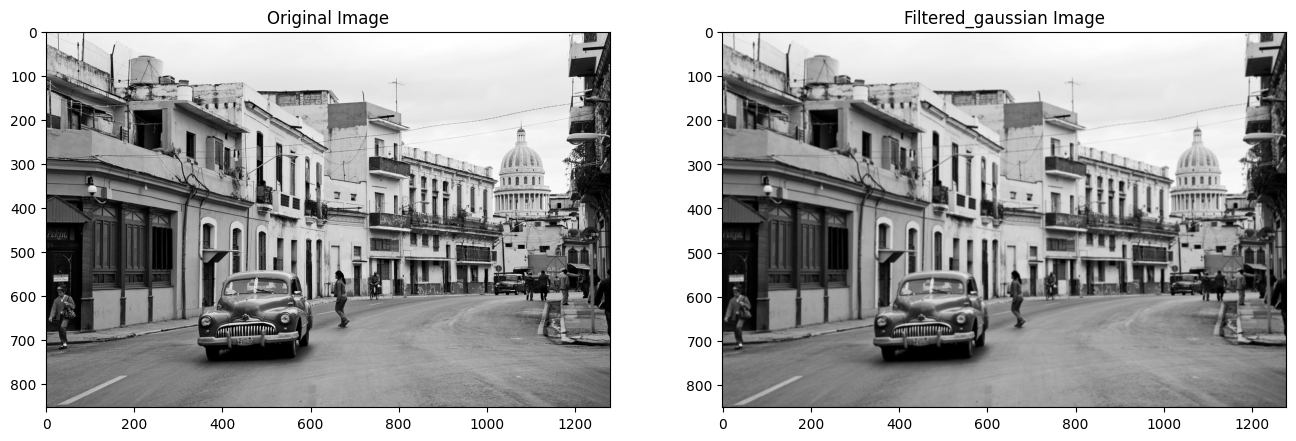

In [16]:
    # Create the filter for gradient in x-direction
    filter_gaussian = np.array([[1, 4, 6, 4 , 1],
                                 [4, 16, 24, 16, 4],
                                 [6, 24, 36, 24, 6],
                                 [4, 16, 24, 16, 4],
                                 [1, 4, 6, 4 , 1]
                                ])

    # Use convolution to apply the Gaussian filter to the image
    Gaussian_filtered_image = F.conv2d(image_tensor, torch.tensor(filter_gaussian, dtype=torch.float32).unsqueeze(0).unsqueeze(0), padding=1)
    # Convert the filtered image tensor to a NumPy array
    Gaussian_filtered_image = Gaussian_filtered_image.squeeze().numpy()
    # Plot the original and filtered images
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_array, cmap='gray')
    # Looping through all cells to overlay the numeric values

    for i in range(grayscale_array.shape[0]):
        for j in range(grayscale_array.shape[1]):
            pixel_value = grayscale_array[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value

    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(Gaussian_filtered_image, cmap='gray')
    # Looping through all cells to overlay the numeric values

    for i in range(Gaussian_filtered_image.shape[0]):
        for j in range(Gaussian_filtered_image.shape[1]):
            pixel_value = Gaussian_filtered_image[i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value

    plt.title("Filtered_gaussian Image")
    plt.show()

## Pooling

Pooling is an operation frequently used in the context of Convolutional Neural Networks (CNNs) for image processing. The main idea behind pooling is to reduce the spatial size of the representation, thereby reducing the number of parameters and computational complexity in the network. This helps in making the network less prone to overfitting and also reduces computation time.

There are several types of pooling operations, with the most common ones being:

**Max Pooling**: In this method, for each segment of the input, the maximum value is selected. For instance, if we consider a 2x2 pooling window (often called a "kernel" in this context) and slide it over an image tensor, the largest value within each 2x2 window will be selected for the pooled output.

- **Average Pooling**: Instead of taking the maximum value in each window, average pooling takes the average value. So for a 2x2 window, it would take the average of all 4 values in that window.
- **Min Pooling**: This operation selects the minimum value from each window, though it's less commonly used than max or average pooling.
- **Global Pooling**: Instead of using a fixed size window, global pooling operates over the entire height and width of the feature map, effectively transforming the spatial dimensions of the feature map to 1x1 (retaining the depth/channels).

The main benefits of pooling include:

- **Dimensionality Reduction**: It reduces the spatial dimensions of the feature maps, which in turn reduces the number of parameters in subsequent layers, leading to faster computations.
- **Invariance to Small Translations**: Small translations in the input image might not lead to significant changes in the pooled feature map. This can be particularly useful when the exact location of features is less relevant than their presence.
- **Prevents Overfitting**: By reducing the spatial resolution and thus the total number of parameters, pooling can help prevent overfitting.


### Max Pooling:
Create a Max Pooling filter of size 8 with stride 2 and run it on the original image.

**TODO:** Explain the output and its shape dimensions.

In [17]:
pool_size = 8
stride = 2
max_pooled_image = F.max_pool2d(image_tensor, kernel_size=pool_size, stride=stride)
print("Shape of Max Pooled Image:", max_pooled_image.shape)

Shape of Max Pooled Image: torch.Size([1, 1, 423, 637])


### Average Pooling:
Create an average pooling filter of size 8 with stride 2 and run it on the original image.

**TODO:** Explain the output and its shape dimensions.

In [18]:

average_pooled_image = F.avg_pool2d(image_tensor, kernel_size=pool_size, stride=stride)
print("Shape of Averrage Pooled Image:", average_pooled_image.shape)

Shape of Averrage Pooled Image: torch.Size([1, 1, 423, 637])


# Section 2: Convolutional Neural Networks

The construction of neural networks is facilitated through the utilization of the ``torch.nn`` package within the PyTorch framework.

A standard process for training a neural network involves the following steps:

1. **Neural Network Definition:** The first step entails defining the architecture of the neural network, which encompasses the design of its interconnected layers and the inclusion of learnable parameters, often referred to as weights.

2. **Iterative Data Processing:** Next, the training procedure involves iterating through a dataset containing input samples. Each input is fed into the neural network for processing.

3. **Forward Propagation:** During this phase, the input data is passed through the neural network's layers, activating its neurons through weighted connections and producing an output prediction.

4. **Loss Computation:** The output generated by the network is then compared to the actual desired output, leading to the computation of a loss value. This loss signifies the discrepancy between the predicted outcome and the true value.

5. **Backpropagation:** After calculating the loss, the gradients of the loss with respect to the network's parameters are computed through a process called backpropagation. This entails tracing how changes in the parameters affect the loss.

6. **Gradient Update:** The gradients computed during backpropagation are used to adjust the network's weights. A common method involves updating the weights by subtracting a scaled gradient value from the current weights. The scale factor, known as the learning rate, determines the step size of the update. This update rule can be expressed as: ``weight = weight - learning_rate * gradient``.

Throughout this iterative process, the neural network's parameters are fine-tuned to minimize the loss and enhance its predictive accuracy. This sequence of steps forms the backbone of training neural networks, enabling them to learn and improve their performance over time.

In this assignment we will create a simple CNN.


To begin this section, we will load the CIFAR10 dataset and train a simple convolutional neural network (CNN) to classify the images.

The CIFAR10 dataset has the classes:

* `airplane`
* `automobile`
* `bird`
* `cat`
* `deer`
* `dog`
* `frog`
* `horse`
* `ship`
* `truck`

The images in CIFAR-10 are of size:

* `3x32x32`

i.e. 3-channel color images of `32x32` pixels in size.

To load the data, we use a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, namely,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.


In the following code, we perform the following:

* Define a batch size for processing multiple images in each iteration.
* Create a series of transformations to be applied to the images in the dataset: converting images to tensors and normalizing the pixel values.
* Load the CIFAR10 **training** and **test** datasets, specifying the root directory, training mode, and transformations.
* Construct a DataLoader for the **training** and **test** datasets with batch processing, shuffling, and parallel data loading.

TODO: Complete the next code block.

In [19]:
# Set the batch size for data processing
batch_size = 4

# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (0.5, 0.5, 0.5)   # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=mean_values, std=std_values)  # Normalize the image data
])
# Load the CIFAR10 training dataset and apply the defined transformations
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)

# Create a DataLoader to efficiently load and process training data in batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Load the CIFAR10 test dataset and apply the same transformations as for training
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create a DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let's view some of the images.

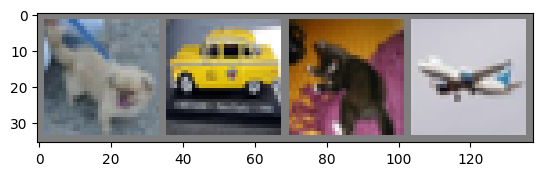

Labels: dog   car   cat   plane


In [20]:

# Define a function to display images
def imshow(img):
    # Unnormalize the image
    # The normalization was done using this formula:
    # img_norm = (img - mean) / std
    # So we unnormalize as follows:
    img = img * 0.5 + 0.5

    npimg = img.numpy()


    #The image array is typically stored in the order [height, width, channels],
    #but the plt.imshow function expects the image array to be stored in the
    #order [channels, width, height].
    #The np.transpose function transposes the image array,
    #so that it is stored in the correct order.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Display the image
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

TODO: Define a simple CNN that classifies CIFAR images.

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the layers of the neural network architecture

        # First convolutional layer: 3 input channels, 6 output channels, kernel size 5x5,no bias
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, bias=False)

        # Max pooling layer with kernel size 2x2 and stride 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer: 6 input channels, 16 output channels, kernel size 5x5, no bias
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, bias=False)

        # Fully connected (dense) layers

        # First fully connected layer: 16*5*5 input features, 120 output features, no bias
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)

        # Second fully connected layer: 120 input features, 84 output features, no bias
        self.fc2 = nn.Linear(120, 84, bias=False)

        # Third fully connected layer: 84 input features, 10 output features (for classification), no bias
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Forward pass through the neural network

        # Apply first convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(torch.relu(self.conv1(x)))
        # Apply second convolutional layer, followed by ReLU activation and max pooling
        x = self.pool(torch.relu(self.conv2(x)))
        # The output from the convolutional and pooling layers is in the form of a
        # 3D tensor (height, width, depth or channels).
        # To feed this tensor into a fully connected layer,
        # it needs to be flattened into a 1D tensor.
        # Reshape tensor for fully connected layers
        # A2D tensor with a shape of [batch_size, 16 * 5 * 5].
        x = x.view(-1, 16 * 5 * 5)
        # Apply first fully connected layer, followed by ReLU activation
        x = torch.relu(self.fc1(x))
        # Apply second fully connected layer, followed by ReLU activation
        x = torch.relu(self.fc2(x))
        # Apply third fully connected layer (output layer)
        x = self.fc3(x)
        return x

# Create an instance of the neural network and move it to the specified device (e.g., GPU)
net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [22]:
def train(model: nn.Module, dataloader: DataLoader):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD optimizer with momentum

    for epoch in range(2):  # Loop over the dataset for multiple epochs
        running_loss = 0.0

        # Iterate over mini-batches of data
        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)  # Move inputs to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            # Zero the gradients in the optimizer
            optimizer.zero_grad()

            # Forward pass + backward pass (backpropagation) + optimization
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # Print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')  # Training loop is complete
    PATH = os.path.join(weights_dir, 'cifar_net.pth')
    torch.save(net.state_dict(), PATH)



In [23]:
train(net, train_loader)

[1,  2000] loss: 2.183
[1,  4000] loss: 1.855
[1,  6000] loss: 1.675
[1,  8000] loss: 1.613
[1, 10000] loss: 1.543
[1, 12000] loss: 1.500
[2,  2000] loss: 1.426
[2,  4000] loss: 1.393
[2,  6000] loss: 1.377
[2,  8000] loss: 1.340
[2, 10000] loss: 1.350
[2, 12000] loss: 1.318
Finished Training


Now that the CNN has been trained, let's test it on our test dataset.

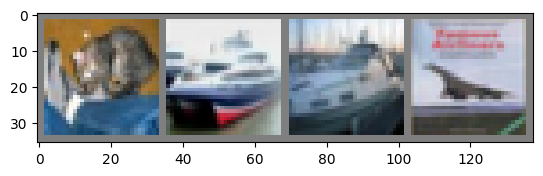

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   car   car   ship 


In [24]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


# net = Net()
# net.load_state_dict(torch.load(PATH))
net.cuda()
images = images.cuda()
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Let us look at how the network performs on the whole dataset.


In [25]:

# A function to evaluate the performance of a given neural network model
# using a test dataset.
# It calculates the accuracy of the model's predictions on the test data.
def calculate_accuracy(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct_predictions = 0  # Initialize the count of correctly predicted samples
    total_samples = 0    # Initialize the count of total samples
    inference_count = 0  # Initialize the count of inferences made

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            images, labels = batch_data  # Separate images and labels from the batch

            images = images.to(device)  # Move images to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            outputs = model(images)  # Forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total_samples += labels.size(0)  # Increment the total count of samples
            correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

            if max_samples:  # Check if a maximum number of samples for testing is specified
                inference_count += images.shape[0]  # Increment the count of inferences made
                if inference_count > max_samples:  # Stop testing if maximum samples reached
                    break

    accuracy = 100 * correct_predictions / total_samples  # Calculate the accuracy as a percentage
    return accuracy

score = calculate_accuracy(net, test_loader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 55.79%


## Question 1: Visualize Weights

Write a function that takes one layer of our network and plots the historgram of its paramters. Use this signature:

```python
def analyze_layer_weights(layer: nn.Module):
```

In [26]:
def analyze_layer_weights(layer: nn.Module):
    # Extract and flatten the weights of the given layer
    layer_weights = layer.weight.data.cpu().view(-1)

    # Get layer type (Conv2d or Linear) for better title
    layer_type = type(layer).__name__

    # Plot a histogram of the flattened layer weights
    plt.hist(layer_weights, density=True, bins=50)
    plt.title(f"{layer_type} Layer Weights Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Density")
    plt.show()

    # Calculate the upper and lower bounds of the range within 3 standard deviations
    layer_weights_3sigma_max = (layer_weights.mean() + 3 * layer_weights.std()).item()
    layer_weights_3sigma_min = (layer_weights.mean() - 3 * layer_weights.std()).item()

    # Calculate the range of weights and the 3-sigma range for the layer
    weight_range = layer_weights.max() - layer_weights.min()
    sigma_range = layer_weights_3sigma_max - layer_weights_3sigma_min

    print(f"{layer_type} Layer Weight Range: {weight_range.item()}")
    print(f"{layer_type} Layer 3-Sigma Range: {sigma_range}")

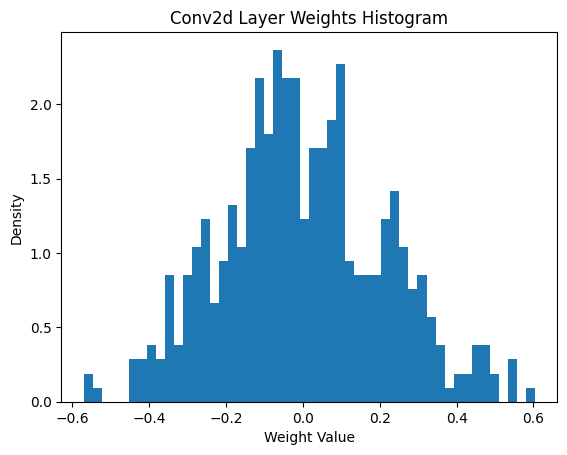

Conv2d Layer Weight Range: 1.1735074520111084
Conv2d Layer 3-Sigma Range: 1.2683579921722412


In [27]:
analyze_layer_weights(net.conv1)

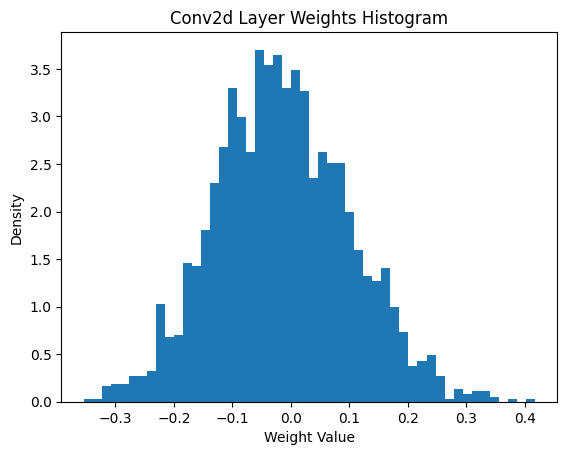

Conv2d Layer Weight Range: 0.7710527181625366
Conv2d Layer 3-Sigma Range: 0.6899514198303223


In [28]:
analyze_layer_weights(net.conv2)

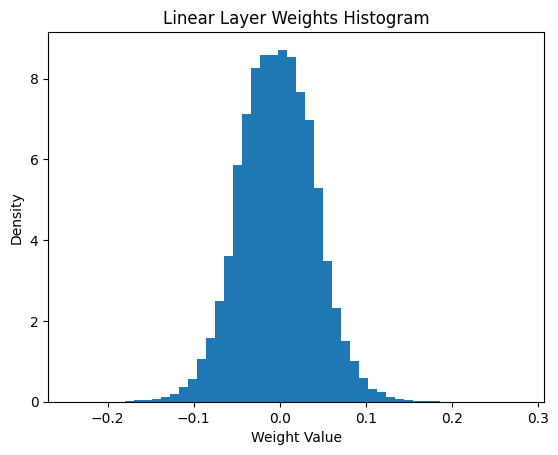

Linear Layer Weight Range: 0.5238115191459656
Linear Layer 3-Sigma Range: 0.25929152965545654


In [29]:
analyze_layer_weights(net.fc1)

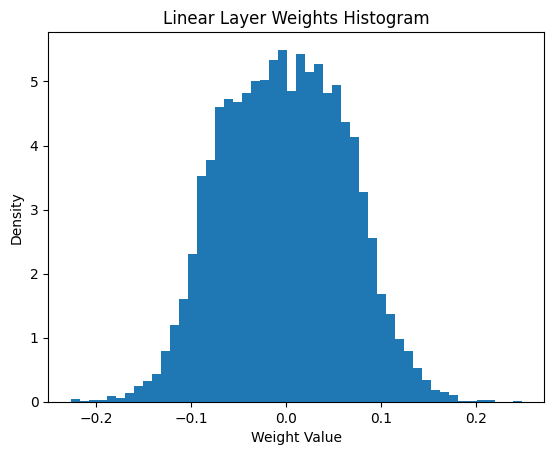

Linear Layer Weight Range: 0.47478237748146057
Linear Layer 3-Sigma Range: 0.3852474093437195


In [30]:
analyze_layer_weights(net.fc2)

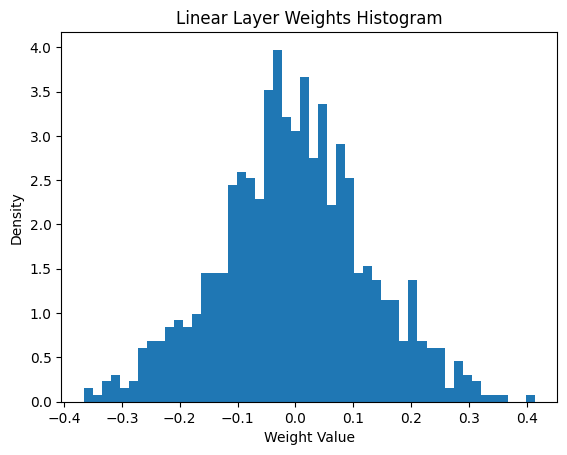

Linear Layer Weight Range: 0.7793804407119751
Linear Layer 3-Sigma Range: 0.7697187066078186


In [31]:
analyze_layer_weights(net.fc3)

## Question 2: Model Dimensions.
TODO:
In the CNN model we have created, how many layers have trainable weights? Please list all the dimensions of each layer's weights.


In [32]:
model = Net()

In [33]:
# TODO1: Count trainable layers and list dimensions
trainable_layers = [layer for layer in model.children() if hasattr(layer, 'weight')]
for i, layer in enumerate(trainable_layers):
    num_params = sum(p.numel() for p in layer.parameters())
    print(f"Layer {i+1}: {layer.__class__.__name__} - Weight Dimensions: {list(layer.weight.shape)}, Trainable Parameters: {num_params}")


Layer 1: Conv2d - Weight Dimensions: [6, 3, 5, 5], Trainable Parameters: 450
Layer 2: Conv2d - Weight Dimensions: [16, 6, 5, 5], Trainable Parameters: 2400
Layer 3: Linear - Weight Dimensions: [120, 400], Trainable Parameters: 48000
Layer 4: Linear - Weight Dimensions: [84, 120], Trainable Parameters: 10080
Layer 5: Linear - Weight Dimensions: [10, 84], Trainable Parameters: 840


TODO: For all the layers with traiable weights, please list their input and output dimension.

In [34]:
#TODO2
# Create a model instance and move it to the specified device
net = Net().to(device)

# Load pretrained weights
weights_dir = '/content/drive/MyDrive/UtilFolder/weights'
weights_path = os.path.join(weights_dir, 'cifar_net.pth')

# Load weights and ensure correct migration between GPU and CPU
checkpoint = torch.load(weights_path, map_location=device)

# Get the key names of the model's state dictionary and weights
model_state_dict = net.state_dict()
weight_keys = list(checkpoint.keys())

# Traverse each layer of the model to obtain input and output dimensions
for layer_name, layer in net.named_children():
    # Check if the layer has trainable weights
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        # Get the weight name, according to the naming convention in the model
        weight_name = f"{layer_name}.weight"

        # Check if the weight name is in the pretrained weights
        if weight_name in weight_keys:
            weight_tensor = checkpoint[weight_name]
            input_dim = weight_tensor.shape[1]  # input dimensions
            output_dim = weight_tensor.shape[0]  # Output dimensions

            print(f"Layer: {layer_name}")
            print(f"Input Dimension: {input_dim}")
            print(f"Output Dimension: {output_dim}")
            print("------------")

Layer: conv1
Input Dimension: 3
Output Dimension: 6
------------
Layer: conv2
Input Dimension: 6
Output Dimension: 16
------------
Layer: fc1
Input Dimension: 400
Output Dimension: 120
------------
Layer: fc2
Input Dimension: 120
Output Dimension: 84
------------
Layer: fc3
Input Dimension: 84
Output Dimension: 10
------------


TODO: For all the layers, please list their total number of multiplications and summations in both forward and backward pass.

In [45]:
# TODO3: Calculate total multiplications and summations for forward and backward passes
# 计算前向传播和反向传播的操作数量
total_forward_mults = 0
total_forward_adds = 0
total_backward_mults = 0
total_backward_adds = 0

input_shape = (3, 32, 32)  # 输入图像的形状

for layer_name, layer in net.named_children():
    if isinstance(layer, nn.Conv2d):
        # 获取卷积层的权重维度
        weight_shape = list(layer.parameters())[0].shape
        input_channels, output_channels = weight_shape[1], weight_shape[0]

        # 计算前向传播操作数量
        forward_mults = input_channels * output_channels * weight_shape[2] * weight_shape[3] * input_shape[1] * input_shape[2]
        forward_adds = output_channels * input_shape[1] * input_shape[2]

        # 反向传播操作数量通常是前向传播的两倍
        backward_mults = 2 * forward_mults
        backward_adds = 2 * forward_adds

        # 更新输入形状以反映卷积层的输出形状
        input_shape = (output_channels, (input_shape[1] - layer.kernel_size[0] + 2 * layer.padding[0]) // layer.stride[0] + 1, (input_shape[2] - layer.kernel_size[1] + 2 * layer.padding[1]) // layer.stride[1] + 1)

        # 累加操作数量
        total_forward_mults += forward_mults
        total_forward_adds += forward_adds
        total_backward_mults += backward_mults
        total_backward_adds += backward_adds

        print(f"Layer: {layer_name}")
        print(f"Forward Mults: {forward_mults}")
        print(f"Forward Adds: {forward_adds}")
        print(f"Backward Mults: {backward_mults}")
        print(f"Backward Adds: {backward_adds}")
        print("------------")

    elif isinstance(layer, nn.Linear):
        # 获取线性层的输入和输出维度
        input_dim, output_dim = layer.in_features, layer.out_features

        # 计算前向传播操作数量
        forward_mults = input_dim * output_dim
        forward_adds = output_dim

        # 反向传播操作数量通常是前向传播的两倍
        backward_mults = 2 * forward_mults
        backward_adds = 2 * forward_adds

        # 累加操作数量
        total_forward_mults += forward_mults
        total_forward_adds += forward_adds
        total_backward_mults += backward_mults
        total_backward_adds += backward_adds

        print(f"Layer: {layer_name}")
        print(f"Forward Mults: {forward_mults}")
        print(f"Forward Adds: {forward_adds}")
        print(f"Backward Mults: {backward_mults}")
        print(f"Backward Adds: {backward_adds}")
        print("------------")

print(f"Total Forward Mults: {total_forward_mults}")
print(f"Total Forward Adds: {total_forward_adds}")
print(f"Total Backward Mults: {total_backward_mults}")
print(f"Total Backward Adds: {total_backward_adds}")


Layer: conv1
Forward Mults: 460800
Forward Adds: 6144
Backward Mults: 921600
Backward Adds: 12288
------------
Layer: conv2
Forward Mults: 1881600
Forward Adds: 12544
Backward Mults: 3763200
Backward Adds: 25088
------------
Layer: fc1
Forward Mults: 48000
Forward Adds: 120
Backward Mults: 96000
Backward Adds: 240
------------
Layer: fc2
Forward Mults: 10080
Forward Adds: 84
Backward Mults: 20160
Backward Adds: 168
------------
Layer: fc3
Forward Mults: 840
Forward Adds: 10
Backward Mults: 1680
Backward Adds: 20
------------
Total Forward Mults: 2401320
Total Forward Adds: 18902
Total Backward Mults: 4802640
Total Backward Adds: 37804


In [46]:
# 创建模型实例
net = Net()

# 初始化输入形状
input_shape = (3, 32, 32)

# 计算前向传播和反向传播的操作数量
total_forward_mults = 0
total_forward_adds = 0
total_backward_mults = 0
total_backward_adds = 0

for layer_name, layer in net.named_children():
    if isinstance(layer, nn.Conv2d):
        # 获取卷积层的权重维度
        weight_shape = list(layer.parameters())[0].shape
        input_channels, output_channels = weight_shape[1], weight_shape[0]

        # 计算前向传播操作数量
        forward_mults = input_channels * output_channels * weight_shape[2] * weight_shape[3] * input_shape[1] * input_shape[2]
        forward_adds = output_channels * input_shape[1] * input_shape[2]

        # 反向传播操作数量通常是前向传播的两倍
        backward_mults = 2 * forward_mults
        backward_adds = 2 * forward_adds

        # 更新输入形状以反映卷积层的输出形状
        input_shape = (output_channels, input_shape[1], input_shape[2])

        # 累加操作数量
        total_forward_mults += forward_mults
        total_forward_adds += forward_adds
        total_backward_mults += backward_mults
        total_backward_adds += backward_adds

        print(f"Layer: {layer_name}")
        print(f"Forward Mults: {forward_mults}")
        print(f"Forward Adds: {forward_adds}")
        print(f"Backward Mults: {backward_mults}")
        print(f"Backward Adds: {backward_adds}")
        print("------------")

    elif isinstance(layer, nn.Linear):
        # 获取线性层的输入和输出维度
        input_dim, output_dim = layer.in_features, layer.out_features

        # 计算前向传播操作数量
        forward_mults = input_dim * output_dim
        forward_adds = output_dim

        # 反向传播操作数量通常是前向传播的两倍
        backward_mults = 2 * forward_mults
        backward_adds = 2 * forward_adds

        # 累加操作数量
        total_forward_mults += forward_mults
        total_forward_adds += forward_adds
        total_backward_mults += backward_mults
        total_backward_adds += backward_adds

        print(f"Layer: {layer_name}")
        print(f"Forward Mults: {forward_mults}")
        print(f"Forward Adds: {forward_adds}")
        print(f"Backward Mults: {backward_mults}")
        print(f"Backward Adds: {backward_adds}")
        print("------------")

print(f"Total Forward Mults: {total_forward_mults}")
print(f"Total Forward Adds: {total_forward_adds}")
print(f"Total Backward Mults: {total_backward_mults}")
print(f"Total Backward Adds: {total_backward_adds}")

Layer: conv1
Forward Mults: 460800
Forward Adds: 6144
Backward Mults: 921600
Backward Adds: 12288
------------
Layer: conv2
Forward Mults: 2457600
Forward Adds: 16384
Backward Mults: 4915200
Backward Adds: 32768
------------
Layer: fc1
Forward Mults: 48000
Forward Adds: 120
Backward Mults: 96000
Backward Adds: 240
------------
Layer: fc2
Forward Mults: 10080
Forward Adds: 84
Backward Mults: 20160
Backward Adds: 168
------------
Layer: fc3
Forward Mults: 840
Forward Adds: 10
Backward Mults: 1680
Backward Adds: 20
------------
Total Forward Mults: 2977320
Total Forward Adds: 22742
Total Backward Mults: 5954640
Total Backward Adds: 45484


TODO: Calculate the maximum memory requirements to run the training for this CNN model. Hint: Weights + gradients + maximum intermediate feature.

In [35]:
# Define batch size and data type
batch_size = 4
dtype = torch.float32  # You can change this to torch.float16 if needed

# Dummy input with the specified batch size and data type
dummy_input = torch.randn(batch_size, 3, 32, 32, dtype=dtype).cuda()

# Enable CUDA if available
if torch.cuda.is_available():
    model.cuda()
    dummy_input = dummy_input.cuda()

# Forward pass to compute the memory usage
with torch.no_grad():
    # Perform a forward pass
    output = model(dummy_input)
    torch.cuda.empty_cache()  # Clear GPU cache to get accurate memory usage

# Calculate memory usage for weights and intermediate features
memory_weights = sum(p.numel() * p.element_size() for p in model.parameters())
memory_gradients = sum(p.numel() * p.element_size() for p in model.parameters())
memory_features = output.numel() * output.element_size()

# Calculate the maximum memory requirement
max_memory = memory_weights + memory_gradients + max(memory_features, memory_gradients)

print(f"Estimated Maximum GPU Memory Requirement (Training): {max_memory / (1024 * 1024):.2f} MB")

Estimated Maximum GPU Memory Requirement (Training): 0.71 MB


## Question 3: Model without MaxPooling2D
TODO: remove the MaxPooling2D layer in the CNN model we have created and adjust the dimension of FC layers to have a matching layer.

TODO: Evaluate the model accuracy and compare it with the CNN model with MaxPooling.

TODO: repeat question 2 for the CNN model without MaxPooling2D.

In [36]:
class ModifiedNet(nn.Module):
    def __init__(self):
        super(ModifiedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, bias=False)
        self.conv2 = nn.Conv2d(6, 1, kernel_size=2, bias=False)
        self.fc1 = nn.Linear(729, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        #print("Conv1 Output Size:", x.shape)
        x = torch.relu(self.conv2(x))
        #print("Conv2 Output Size:", x.shape)
        x = x.view(-1, 729)
        #print("Flatten Output Size:", x.shape)
        x = torch.relu(self.fc1(x))
        #print("FC1 Output Size:", x.shape)
        x = torch.relu(self.fc2(x))
        #print("FC2 Output Size:", x.shape)
        x = self.fc3(x)
        #print("FC3 Output Size:", x.shape)
        return x

modified_model = ModifiedNet().to(device)


In [37]:
#Train the modified Model
def train1(model: nn.Module, dataloader: DataLoader):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD optimizer with momentum

    for epoch in range(2):  # Loop over the dataset for multiple epochs
        running_loss = 0.0

        # Iterate over mini-batches of data
        for i, data in enumerate(dataloader, 0):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)  # Move inputs to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            # Zero the gradients in the optimizer
            optimizer.zero_grad()

            # Forward pass + backward pass (backpropagation) + optimization
            outputs = model(inputs)  # Forward pass through the model
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # Print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')  # Training loop is complete
    PATH = os.path.join(weights_dir, 'cifar_net1.pth')
    torch.save(modified_model.state_dict(), PATH)

In [38]:
train1(modified_model, train_loader)

[1,  2000] loss: 2.277
[1,  4000] loss: 2.175
[1,  6000] loss: 2.088
[1,  8000] loss: 2.019
[1, 10000] loss: 1.923
[1, 12000] loss: 1.890
[2,  2000] loss: 1.855
[2,  4000] loss: 1.830
[2,  6000] loss: 1.807
[2,  8000] loss: 1.792
[2, 10000] loss: 1.783
[2, 12000] loss: 1.762
Finished Training


In [39]:
#the performance of modified_model
def calculate_accuracy(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct_predictions = 0  # Initialize the count of correctly predicted samples
    total_samples = 0    # Initialize the count of total samples
    inference_count = 0  # Initialize the count of inferences made

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_data in dataloader:
            images, labels = batch_data  # Separate images and labels from the batch

            images = images.to(device)  # Move images to the specified device
            labels = labels.to(device)  # Move labels to the specified device

            outputs = model(images)  # Forward pass to get model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class indices

            total_samples += labels.size(0)  # Increment the total count of samples
            correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

            if max_samples:  # Check if a maximum number of samples for testing is specified
                inference_count += images.shape[0]  # Increment the count of inferences made
                if inference_count > max_samples:  # Stop testing if maximum samples reached
                    break

    accuracy = 100 * correct_predictions / total_samples  # Calculate the accuracy as a percentage
    return accuracy

score = calculate_accuracy(modified_model, test_loader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 36.9%


In [40]:
# TODO1: Count trainable layers and list dimensions
trainable_layers = [layer for layer in modified_model.children() if hasattr(layer, 'weight')]
for i, layer in enumerate(trainable_layers):
    num_params = sum(p.numel() for p in layer.parameters())
    print(f"Layer {i+1}: {layer.__class__.__name__} - Weight Dimensions: {list(layer.weight.shape)}, Trainable Parameters: {num_params}")

Layer 1: Conv2d - Weight Dimensions: [6, 3, 5, 5], Trainable Parameters: 450
Layer 2: Conv2d - Weight Dimensions: [1, 6, 2, 2], Trainable Parameters: 24
Layer 3: Linear - Weight Dimensions: [120, 729], Trainable Parameters: 87480
Layer 4: Linear - Weight Dimensions: [84, 120], Trainable Parameters: 10080
Layer 5: Linear - Weight Dimensions: [10, 84], Trainable Parameters: 840


In [41]:
#TODO2
# 加载预训练权重
weights_dir = '/content/drive/MyDrive/UtilFolder/weights'
weights_path = os.path.join(weights_dir, 'cifar_net1.pth')

# 加载权重并确保在GPU和CPU之间正确迁移
checkpoint = torch.load(weights_path, map_location=device)

# 获取模型的状态字典和权重的键名称
model_state_dict = modified_model.state_dict()
weight_keys = list(checkpoint.keys())

# 遍历模型的各个层，获取输入和输出维度
for layer_name, layer in modified_model.named_children():
    # 检查层是否有可训练权重
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        # 获取权重名称，根据模型中的命名约定
        weight_name = f"{layer_name}.weight"

        # 检查权重名称是否在预训练权重中
        if weight_name in weight_keys:
            weight_tensor = checkpoint[weight_name]
            input_dim = weight_tensor.shape[1]  # 输入维度
            output_dim = weight_tensor.shape[0]  # 输出维度

            print(f"Layer: {layer_name}")
            print(f"Input Dimension: {input_dim}")
            print(f"Output Dimension: {output_dim}")
            print("------------")

Layer: conv1
Input Dimension: 3
Output Dimension: 6
------------
Layer: conv2
Input Dimension: 6
Output Dimension: 1
------------
Layer: fc1
Input Dimension: 729
Output Dimension: 120
------------
Layer: fc2
Input Dimension: 120
Output Dimension: 84
------------
Layer: fc3
Input Dimension: 84
Output Dimension: 10
------------


In [42]:
# Calculate the total number of multiplications and summations for both forward and backward passes
total_forward_mults = 0
total_forward_adds = 0
total_backward_mults = 0
total_backward_adds = 0

for layer_name, layer in modified_model.named_children():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        input_dim = None
        output_dim = None
        kernel_size = None

        if isinstance(layer, nn.Conv2d):
            # For Conv2d layers, input_dim is the number of input channels,
            # output_dim is the number of output channels, and kernel_size
            # is the kernel size (product of spatial dimensions).
            input_dim = layer.in_channels
            output_dim = layer.out_channels
            kernel_size = torch.prod(torch.tensor(layer.kernel_size))

        elif isinstance(layer, nn.Linear):
            # For Linear layers, input_dim is the number of input features,
            # and output_dim is the number of output features.
            input_dim = layer.in_features
            output_dim = layer.out_features

        # Calculate forward pass operations
        forward_mults = input_dim * output_dim * kernel_size if kernel_size is not None else input_dim * output_dim
        forward_adds = output_dim

        # Calculate backward pass operations (assuming gradients are also computed)
        backward_mults = 2 * forward_mults
        backward_adds = 2 * forward_adds

        # Accumulate operations
        total_forward_mults += forward_mults
        total_forward_adds += forward_adds
        total_backward_mults += backward_mults
        total_backward_adds += backward_adds

        print(f"Layer: {layer_name}")
        print(f"Forward Mults: {forward_mults}")
        print(f"Forward Adds: {forward_adds}")
        print(f"Backward Mults: {backward_mults}")
        print(f"Backward Adds: {backward_adds}")
        print("------------")

print(f"Total Forward Mults: {total_forward_mults}")
print(f"Total Forward Adds: {total_forward_adds}")
print(f"Total Backward Mults: {total_backward_mults}")
print(f"Total Backward Adds: {total_backward_adds}")


Layer: conv1
Forward Mults: 450
Forward Adds: 6
Backward Mults: 900
Backward Adds: 12
------------
Layer: conv2
Forward Mults: 24
Forward Adds: 1
Backward Mults: 48
Backward Adds: 2
------------
Layer: fc1
Forward Mults: 87480
Forward Adds: 120
Backward Mults: 174960
Backward Adds: 240
------------
Layer: fc2
Forward Mults: 10080
Forward Adds: 84
Backward Mults: 20160
Backward Adds: 168
------------
Layer: fc3
Forward Mults: 840
Forward Adds: 10
Backward Mults: 1680
Backward Adds: 20
------------
Total Forward Mults: 98874
Total Forward Adds: 221
Total Backward Mults: 197748
Total Backward Adds: 442


In [43]:
# Calculate operation counts for the modified model
total_forward_mults = 0
total_forward_adds = 0
total_backward_mults = 0
total_backward_adds = 0

for layer_name, layer in modified_model.named_children():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        weight_shape = list(layer.parameters())[0].shape
        input_channels, output_channels = weight_shape[1], weight_shape[0]

        if isinstance(layer, nn.Conv2d):
            # For convolutional layers, calculate the forward and backward operations based on weight shapes
            input_size = 32  # Assuming input size of 32x32 (change if different)
            forward_mults = input_channels * output_channels * weight_shape[2] * weight_shape[3] * input_size * input_size
            forward_adds = output_channels * input_size * input_size
            backward_mults = 2 * forward_mults
            backward_adds = 2 * forward_adds
        elif isinstance(layer, nn.Linear):
            # For linear layers, calculate the forward and backward operations based on input and output dimensions
            input_dim, output_dim = input_channels, output_channels
            forward_mults = input_dim * output_dim
            forward_adds = output_dim
            backward_mults = 2 * forward_mults
            backward_adds = 2 * forward_adds

        total_forward_mults += forward_mults
        total_forward_adds += forward_adds
        total_backward_mults += backward_mults
        total_backward_adds += backward_adds

        print(f"Layer: {layer_name}")
        print(f"Forward Mults: {forward_mults}")
        print(f"Forward Adds: {forward_adds}")
        print(f"Backward Mults: {backward_mults}")
        print(f"Backward Adds: {backward_adds}")
        print("------------")

print(f"Total Forward Mults: {total_forward_mults}")
print(f"Total Forward Adds: {total_forward_adds}")
print(f"Total Backward Mults: {total_backward_mults}")
print(f"Total Backward Adds: {total_backward_adds}")

Layer: conv1
Forward Mults: 460800
Forward Adds: 6144
Backward Mults: 921600
Backward Adds: 12288
------------
Layer: conv2
Forward Mults: 24576
Forward Adds: 1024
Backward Mults: 49152
Backward Adds: 2048
------------
Layer: fc1
Forward Mults: 87480
Forward Adds: 120
Backward Mults: 174960
Backward Adds: 240
------------
Layer: fc2
Forward Mults: 10080
Forward Adds: 84
Backward Mults: 20160
Backward Adds: 168
------------
Layer: fc3
Forward Mults: 840
Forward Adds: 10
Backward Mults: 1680
Backward Adds: 20
------------
Total Forward Mults: 583776
Total Forward Adds: 7382
Total Backward Mults: 1167552
Total Backward Adds: 14764


In [44]:
#TODO4: modified_model
# Define batch size and data type
batch_size = 4
dtype = torch.float32  # You can change this to torch.float16 if needed

# Dummy input with the specified batch size and data type
dummy_input = torch.randn(batch_size, 3, 32, 32, dtype=dtype).cuda()

# Enable CUDA if available
if torch.cuda.is_available():
    modified_model.cuda()
    dummy_input = dummy_input.cuda()

# Forward pass to compute the memory usage
with torch.no_grad():
    # Perform a forward pass
    output = modified_model(dummy_input)
    torch.cuda.empty_cache()  # Clear GPU cache to get accurate memory usage

# Calculate memory usage for weights and intermediate features
memory_weights = sum(p.numel() * p.element_size() for p in modified_model.parameters())
memory_gradients = sum(p.numel() * p.element_size() for p in modified_model.parameters())
memory_features = output.numel() * output.element_size()

# Calculate the maximum memory requirement
max_memory = memory_weights + memory_gradients + max(memory_features, memory_gradients)

print(f"Estimated Maximum GPU Memory Requirement (Training): {max_memory / (1024 * 1024):.2f} MB")

Estimated Maximum GPU Memory Requirement (Training): 1.13 MB
